# Visualise Toy Datasets and Best Response
This notebook provides the code to visualise 2D toy datasets from the /data/ directory and to visualise the impact of the best response on the data

## Install pre-requisites

In [17]:
! pip install matplotlib
! pip install ipympl
! pip install imageio[ffmpeg]
! pip install numpy
#! pip install pandas
#! pip install torch
#! pip install "numpy<2"

%load_ext autoreload

zsh:1: no matches found: imageio[ffmpeg]


In [2]:
# Allow relative importing from Clf_Learner module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Extracting Data Scripts

In [3]:
from Clf_Learner.tools.dataset_building_tools import get_dataset
from Clf_Learner.interfaces.base_dataset import BaseDataset
from torch import Tensor

def get_data(data_address, target_index=-1) -> tuple[Tensor, Tensor, BaseDataset|None]:
    dataset = get_dataset(data_address, target_index)

    X, y = Tensor([]), Tensor([])
    if dataset is not None:
        X, y = dataset.get_all_vals()

    return X, y, dataset 

## Visualising Data Scripts

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
def visualize_data2D(X, y):
    """Visualise 2D Dataset"""
    assert X.size(1) == 2
    if not X.size(1) == 2:
        return
    
    Xpos = X[y == 1]
    Xneg = X[y == -1]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='red')
    plt.show()

In [5]:
%matplotlib inline

import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch

from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import display
from IPython.core.display import HTML

MAX_NUM_FRAMES = 50

def visualize_seperator2D(model, X, y, x_lim=None, z_lim=None, no_lim=False,
                          animate=False, store=False, interval=300, fps=5):
    """
    X: tensor (F, N, 2) if animate else (N,2)
    y: tensor (N,) or (N,1) with labels in {1, -1}
    """
    assert X.size(-1) == 2, "Error: Visualisation can only be performed for 2D data"
    assert model.x_dim == 2, "Error: Visualisation can only be performed for models trained on 2D data"
    assert hasattr(model, "get_boundary_vals"), "Error: Visualisation requires model has 'get_boundary_vals' function defined"
    assert x_lim is None or (isinstance(x_lim, list|tuple) and len(x_lim)==2)
    assert z_lim is None or (isinstance(z_lim, list|tuple) and len(z_lim)==2)

    # Convert to Numpy for efficiency
    X = X.detach().cpu().numpy()
    if animate:
        assert len(X.shape) == 3, "Error: For animate=True, X must be (F,N,2)"
        F, N, D = X.shape
        # downsample frames if needed
        if F > MAX_NUM_FRAMES:
            idx = torch.linspace(0, F-1, steps=MAX_NUM_FRAMES, dtype=torch.long).tolist()
            if idx[-1] != F-1: idx.append(F-1)
            X = X[idx]
        frames = X.shape[0]
    else:
        assert len(X.shape) == 2, "Error: For animate=False, X must be (N,2)"
        frames = 1

    y = y.detach().cpu().numpy()

    # compute global limits across all frames
    flat = X.reshape(-1,2)
    x_low0, z_low0 = flat.min(axis=0).tolist()
    x_high0, z_high0 = flat.max(axis=0).tolist()
    x_low, x_high = (x_lim if x_lim is not None else (x_low0, x_high0))
    z_low, z_high = (z_lim if z_lim is not None else (z_low0, z_high0))

    # --- Prepare figure & initial artists ---
    fig, ax = plt.subplots()
    if not no_lim:
        ax.set_xlim(x_low, x_high)
        ax.set_ylim(z_low, z_high)

    first_frame = X[0] if animate else X
    pos0 = first_frame[y == 1]
    neg0 = first_frame[y == -1]

    scat_pos = ax.scatter(pos0[:,0], pos0[:,1], marker='+', color='blue', label='Pos')
    scat_neg = ax.scatter(neg0[:,0], neg0[:,1], marker='_', color='red', label='Neg')

    # prepare range tensor for model boundary (use same device as X_torch)
    range_t = torch.arange(int(x_low)-1, int(x_high)+1, 0.1)

    # initial boundary lines (model.get_boundary_vals may return list or single tensor)
    bcs = model.get_boundary_vals(range_t)
    if not isinstance(bcs, list):
        bcs = [bcs]
    lines = []
    for bc in bcs:
        bc_np = bc.detach().cpu().numpy()
        line, = ax.plot(bc_np[:,0], bc_np[:,1], linestyle='dashed', linewidth=2.0, alpha=0.75, color='green')
        lines.append(line)

    ax.legend(loc='upper right')

    if not animate:
        # Don't render in widget if not animating
        plt.show()
        return None

    # --- Update function (updates existing artists) ---
    def update(i):
        frame = X[i]
        pos = frame[y == 1]
        neg = frame[y == -1]
        if pos.size == 0:
            scat_pos.set_offsets(np.empty((0,2)))
        else:
            scat_pos.set_offsets(pos)
        if neg.size == 0:
            scat_neg.set_offsets(np.empty((0,2)))
        else:
            scat_neg.set_offsets(neg)

        # return artists (works when blit=False too, safe)
        return [scat_pos, scat_neg] + lines

    # --- Build & embed animation ---
    ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=False, repeat=False)

    # preferred: embed as JS animation in notebook (reliable in VS Code/Jupyter)
    #ani_plot = ani.to_html5_video() # mpeg video
    ani_plot = ani.to_jshtml() # interactive window
    display(HTML(ani_plot))

    # optional: save GIF if requested
    if store:
        gif_label = f"{datetime.datetime.now():%Y-%m-%d_%H_%M}"
        gifname = f"best_response_{gif_label}.gif"
        ani.save(f"{gifname}", dpi=150, writer=PillowWriter(fps=fps))
        print(f"Animation saved to {gifname}")

    plt.close(fig)
    return ani

## Parameter Setting
Here you specify the dataset you want to visualise and the subdirectory of ../results that contains the model specifications that you want to visualise the decision boundary of. 
Note: Datasets being visualised must be 2D datasets, and models whose decision boundaries are being visualised must have been trained on that dataset. 

In [6]:
path_to_root = "/Users/jackgeary/Code/Randomised_Classifier_Learning"

In [7]:
dataset_name = "normal_data_dist_5_std_1_5" 
#dataset_name = "ball_half_ring_dataset_ball_rad_2_in_rad_3_out_rad_5"
#dataset_name = "ball_half_ring_inverted_dataset_ball_rad_2_in_rad_3_out_rad_5"
#dataset_name = "ball_ring_dataset_ball_rad_2_in_rad_3_out_rad_5"
#dataset_name = "twin_moons"

In [8]:
model_results_dirname = "dummy_linear_model"

## Visualising Data

Standardising Dataset


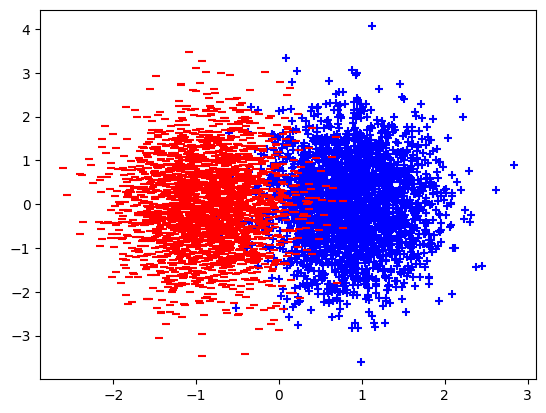

In [9]:
data_address = f"{path_to_root}/data/{dataset_name}.csv"
X, y, dataset = get_data(data_address, -1)
visualize_data2D(X, y)

## Visualising Model Decision Boundary

In [10]:
from Clf_Learner.main import _load_args
# Bad practise to import underscored function. But I'm gonna let it slide because this isn't getting released
import Clf_Learner.tools.utils as utils
utils.RESULTS_DIR = f"{path_to_root}/results"

args = _load_args(f"{utils.RESULTS_DIR}/{model_results_dirname}/commandline_args.json")

In [11]:
from Clf_Learner.tools.results_tools import fetch_model
from Clf_Learner.tools.model_building_tools import get_model, get_model_spec

if args.specs:
    model_spec = get_model_spec(model_spec_name=args.specs[0])
else:
    model_spec = get_model_spec(br_name=args.best_response, cost_name=args.cost, loss_name=args.loss, model_type_name=args.model, utility_name=args.utility)

init_args = {"x_dim": X.shape[1]}
comp_args = args.args

implicit = False # Implicit shouldn't matter for evaluating trained model

model = get_model(model_spec, model_results_dirname, dataset, implicit, init_args, comp_args)
model = fetch_model(model, model_results_dirname, dataset_name, model_spec)

In [12]:
x_high, z_high = torch.max(X,0).values.tolist()
x_low, z_low = torch.min(X,0).values.tolist()

a = model.best_response(X, model, y=y).detach()

## Plot Decision Boundary with Data with no Strategic Response

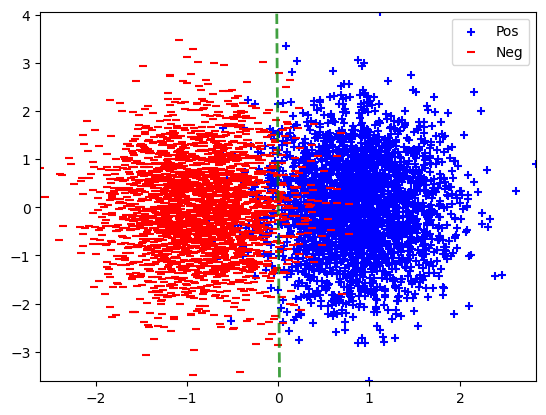

In [13]:
visualize_seperator2D(model, X, y)

## Plot Decision Boundary with Data with Strategic Response

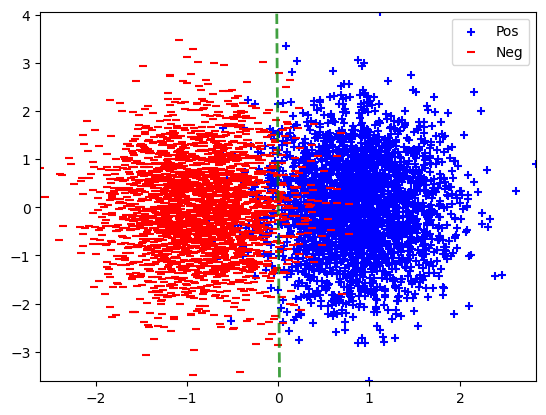

In [14]:
visualize_seperator2D(model, a, y, x_lim=(x_low, x_high), z_lim=(z_low, z_high))

# Test Other Best Response Definitions
Code here allows you to test out what a different best response definitions would look like when applied to a fixed model

In [13]:
# Define you Cost
from Clf_Learner.costs import COST_DICT

target_radius = 2
target_eps = (target_radius**2)/4

cost_name = "quadratic"
cost_args = {"eps": target_eps}

cost = COST_DICT[cost_name]
cost = cost(**cost_args)

assert dataset is not None
cost.set_standardiser(dataset.get_standardiser())

In [14]:
from Clf_Learner.utilities import UTILITY_DICT

utility_name = "strategic"
utility_args = {"margin": 0.01}

utility = UTILITY_DICT[utility_name]
utility = utility(**utility_args)

In [19]:
%autoreload

from Clf_Learner.best_reponses import BR_DICT

best_response_name = "lagrange"
br_args = {"max_iterations": 12000, "lr":0.0003, "margin": 5e-2, "lagrange_mult_lr": 5e-4, "lagrange_mult_cost_lr": 5e-2}

best_response = BR_DICT[best_response_name]
best_response = best_response(cost=cost, utility=utility, **br_args)

In [ ]:
br = best_response(X, model, debug=True)

In [ ]:
x_high, z_high = torch.max(X,0).values.tolist()
x_low, z_low = torch.min(X,0).values.tolist()

visualize_seperator2D(model, X, y)
visualize_seperator2D(model, br, y, x_lim=(x_low, x_high), z_lim=(z_low, z_high), animate=False, store=False)